## (i) Importing the necessary packages

In [3]:
%pip install keras-nlp

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Reference 1: Vaswani, Ashish, et al. “Attention Is All You Need.” ArXiv.org, 6 Dec. 2017, https://arxiv.org/abs/1706.03762. 
#Reference 2: Keras Team. “Keras Documentation: Transformerencoder Layer.” Keras, https://keras.io/api/keras_nlp/layers/transformer_encoder/. 
#Reference 3: Monsoor, Tonmoy, et al. "CNN with data preprocessing.ipynb." BruinLearn, https://bruinlearn.ucla.edu/courses/154235/files/12794459/download?download_frd=1

#The following code is adopted from the "CNN with data preprocessing.ipynb." by Tonmoy Monsoor from ECE C247.

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout,Reshape
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape, LeakyReLU
from keras.utils import to_categorical
from keras_nlp.layers import TransformerEncoder
import matplotlib.pyplot as plt
import pickle

np.random.seed(12345)

## (ii)(a) Loading and visualizing the dataset 

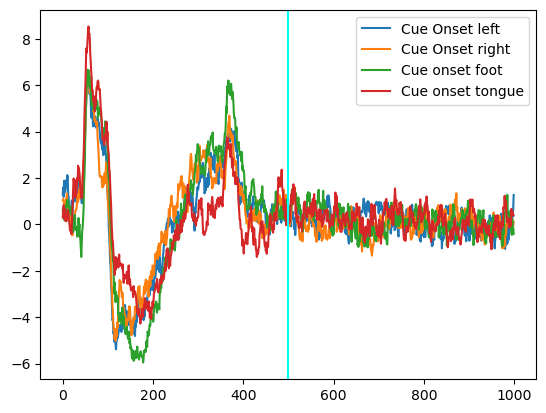

In [5]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("/kaggle/input/ece-c247-final-project/X_test.npy")
y_test = np.load("/kaggle/input/ece-c247-final-project/y_test.npy")
person_train_valid = np.load("/kaggle/input/ece-c247-final-project/person_train_valid.npy")
X_train_valid = np.load("/kaggle/input/ece-c247-final-project/X_train_valid.npy")
y_train_valid = np.load("/kaggle/input/ece-c247-final-project/y_train_valid.npy")
person_test = np.load("/kaggle/input/ece-c247-final-project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





## (ii)(b) Preprocessing the dataset

![EEG_prep.png](attachment:EEG_prep.png)

In [6]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


## (iii) Defining the architecture of CNN+Transformer model

In [7]:
def CNN_Transformer(intermediate_dim=6, num_heads=2):
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()
    # Conv. block 1
    basic_cnn_model.add(TransformerEncoder(intermediate_dim=intermediate_dim,num_heads=num_heads,dropout=0.5,activation="elu"))
    basic_cnn_model.add(Reshape((250,1,22)))

    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4

    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))


    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    basic_cnn_model.build((None,250,22))

    # Printing the model summary
    #basic_cnn_model.summary()
    return basic_cnn_model

## (iii) Defining the architecture of CNN+Transformer+LSTM model

In [8]:
from keras.layers import LSTM
def CNN_Transformer_LSTM(intermediate_dim=6, num_heads=2):
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()
    # Conv. block 1
    basic_cnn_model.add(TransformerEncoder(intermediate_dim=intermediate_dim,num_heads=num_heads,dropout=0.5,activation="elu"))
    basic_cnn_model.add(Reshape((250,1,22)))

    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4

    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))
    
    basic_cnn_model.add(Flatten())
    basic_cnn_model.add(Dense((100)))
    basic_cnn_model.add(Reshape((100,1)))
    basic_cnn_model.add(LSTM(units=150, dropout=0.5, recurrent_dropout=0,return_sequences=False))
    basic_cnn_model.add(Flatten())
    basic_cnn_model.add(Dense((100)))
    basic_cnn_model.add(Reshape((100,1)))
    basic_cnn_model.add(LSTM(units=150, dropout=0.5, recurrent_dropout=0,return_sequences=False))


    # Output layer with Softmax activation
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    basic_cnn_model.build((None,250,22))

    # Printing the model summary
    basic_cnn_model.summary()
    return basic_cnn_model

## (iv) Defining the hyperparameters of the CNN+Transformer and CNN+Transformer+LSTM model

In [9]:
from tensorflow import keras
#from keras.optimizers import schedules
# Model parameters
learning_rate = 1e-3
epochs = 100
decay_steps = 1000
cnn_optimizer = keras.optimizers.experimental.AdamW(learning_rate=learning_rate)

transformer_cnn_model = CNN_Transformer(intermediate_dim=6, num_heads=2)
transformer_cnn_lstm_model = CNN_Transformer_LSTM(intermediate_dim=6, num_heads=2)


/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder_1 (Tran  (None, 250, 22)          2404      
 sformerEncoder)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 250, 1, 22)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 250, 1, 50)        11050     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 1, 50)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 84, 1, 50)        200       
 hNormalization)                                                 
                                                      

## (iv) Compiling the CNN+Transformer model and Training the model based on the whole train_valid datasets. 

In [9]:
# Compiling the model cnn_transformer


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
x_train_valid_p = np.swapaxes(X_train_valid_prep, 2,1)
y_train_valid_p = to_categorical(y_train_valid_prep, 4)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)
y_test = to_categorical(y_test_prep, 4)
x_test = np.swapaxes(X_test_prep, 2,1)


transformer_cnn_model = CNN_Transformer(intermediate_dim=6, num_heads=2)

transformer_cnn_model.compile(loss='categorical_crossentropy',
             optimizer=cnn_optimizer,
             metrics=['accuracy'])

# Training and validating the model
transformer_cnn_model_results = transformer_cnn_model.fit(x_train_valid_p,
                         y_train_valid_p,
                         batch_size=64,
                         epochs=epochs,
                         verbose=True)

Epoch 1/100


2023-03-18 06:08:34.707483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 15s 14ms/step - loss: 1.8910 - accuracy: 0.3106
Epoch 2/100
133/133 [==============================] - 2s 13ms/step - loss: 1.4648 - accuracy: 0.3805
Epoch 3/100
133/133 [==============================] - 2s 13ms/step - loss: 1.2601 - accuracy: 0.4535
Epoch 4/100
133/133 [==============================] - 2s 13ms/step - loss: 1.1625 - accuracy: 0.5017
Epoch 5/100
133/133 [==============================] - 2s 13ms/step - loss: 1.0915 - accuracy: 0.5381
Epoch 6/100
133/133 [==============================] - 2s 15ms/step - loss: 1.0419 - accuracy: 0.5660
Epoch 7/100
133/133 [==============================] - 2s 13ms/step - loss: 0.9872 - accuracy: 0.5936
Epoch 8/100
133/133 [==============================] - 2s 13ms/step - loss: 0.9382 - accuracy: 0.6178
Epoch 9/100
133/133 [==============================] - 2s 13ms/step - loss: 0.8880 - accuracy: 0.6440
Epoch 10/100
133/133 [==============================] - 2s 14ms/step - loss: 0.8356 - accurac

In [12]:
#Compile the subject info for each instance in the processing testing set. 

person_test_1=person_test.reshape((person_test.shape[0]))
person_test_prep = person_test_1
person_test_prep=np.hstack((person_test_prep, person_test_1))
person_test_prep = np.hstack((person_test_prep, person_test_1))
person_test_prep = np.hstack((person_test_prep, person_test_1))

print(person_test_prep.shape)

(1772,)


## (v) Evaulate the CNN+Transformer model based on different subjects from the testing sets and the overall testing sets. 

In [11]:
all_results=np.zeros(9)

for i in range(9):
    cnn_score = transformer_cnn_model.evaluate(x_test[person_test_prep==i], y_test[person_test_prep==i], verbose=0)[1]
    all_results[i]=cnn_score
    print("Test accuracy for CNN_Transformer model on subject ",i+1,cnn_score)
cnn_score = transformer_cnn_model.evaluate(x_test, y_test, verbose=0)[1]
all_results[-1]=cnn_score
print('Test accuracy of CNN_Transformer model on all subjects:',all_results[-1])
np.save("cnn_transformer_testing_on_each_subject_all=0.75_final.npy",all_results)

Test accuracy for CNN_Transformer model on subject  1 0.7549999952316284
Test accuracy for CNN_Transformer model on subject  2 0.6449999809265137
Test accuracy for CNN_Transformer model on subject  3 0.7749999761581421
Test accuracy for CNN_Transformer model on subject  4 0.7300000190734863
Test accuracy for CNN_Transformer model on subject  5 0.7872340679168701
Test accuracy for CNN_Transformer model on subject  6 0.6938775777816772
Test accuracy for CNN_Transformer model on subject  7 0.800000011920929
Test accuracy for CNN_Transformer model on subject  8 0.7850000262260437
Test accuracy for CNN_Transformer model on subject  9 0.8563829660415649
Test accuracy of CNN_Transformer model on all subjects: 0.7579006552696228


## (vi) Compiling the CNN+Transformer+LSTM model and Training the model based on the whole train_valid datasets. 

In [10]:
X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
x_train_valid_p = np.swapaxes(X_train_valid_prep, 2,1)
y_train_valid_p = to_categorical(y_train_valid_prep, 4)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)
y_test = to_categorical(y_test_prep, 4)
x_test = np.swapaxes(X_test_prep, 2,1)


transformer_cnn_lstm_model = CNN_Transformer_LSTM(intermediate_dim=6, num_heads=2)

transformer_cnn_lstm_model.compile(loss='categorical_crossentropy',
             optimizer=cnn_optimizer,
             metrics=['accuracy'])

# Training and validating the model
transformer_cnn_lstm_model_results = transformer_cnn_lstm_model.fit(x_train_valid_p,
                         y_train_valid_p,
                         batch_size=64,
                         epochs=epochs,
                         verbose=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder_2 (Tran  (None, 250, 22)          2404      
 sformerEncoder)                                                 
                                                                 
 reshape_4 (Reshape)         (None, 250, 1, 22)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 250, 1, 50)        11050     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 84, 1, 50)        0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 84, 1, 50)        200       
 hNormalization)                                                 
                                                      

2023-03-18 06:22:52.916279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 22s 34ms/step - loss: 1.3512 - accuracy: 0.3152
Epoch 2/100
133/133 [==============================] - 5s 34ms/step - loss: 1.2950 - accuracy: 0.3855
Epoch 3/100
133/133 [==============================] - 4s 34ms/step - loss: 1.2587 - accuracy: 0.4069
Epoch 4/100
133/133 [==============================] - 5s 36ms/step - loss: 1.2266 - accuracy: 0.4310
Epoch 5/100
133/133 [==============================] - 4s 34ms/step - loss: 1.1987 - accuracy: 0.4480
Epoch 6/100
133/133 [==============================] - 5s 34ms/step - loss: 1.1732 - accuracy: 0.4716
Epoch 7/100
133/133 [==============================] - 5s 34ms/step - loss: 1.1362 - accuracy: 0.4900
Epoch 8/100
133/133 [==============================] - 4s 34ms/step - loss: 1.0988 - accuracy: 0.5070
Epoch 9/100
133/133 [==============================] - 5s 35ms/step - loss: 1.0673 - accuracy: 0.5294
Epoch 10/100
133/133 [==============================] - 5s 34ms/step - loss: 1.0410 - accurac

## (vii) Evaulate the CNN+Transformer+LSTM model based on different subjects from the testing sets and the overall testing sets. . 

In [13]:
all_results=np.zeros(9)

for i in range(9):
    cnn_score = transformer_cnn_lstm_model.evaluate(x_test[person_test_prep==i], y_test[person_test_prep==i], verbose=0)[1]
    all_results[i]=cnn_score
    print("Test accuracy for CNN_Transformer_LSTM model on subject ",i+1,cnn_score)
cnn_score = transformer_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)[1]
all_results[-1]=cnn_score
print('Test accuracy of CNN_Transformer_LSTM model on all subjects:',all_results[-1])
np.save("cnn_transformer_lstm_testing_on_each_subject_all=0.75_final.npy",all_results)

Test accuracy for CNN_Transformer_LSTM model on subject  1 0.6949999928474426
Test accuracy for CNN_Transformer_LSTM model on subject  2 0.550000011920929
Test accuracy for CNN_Transformer_LSTM model on subject  3 0.6850000023841858
Test accuracy for CNN_Transformer_LSTM model on subject  4 0.6700000166893005
Test accuracy for CNN_Transformer_LSTM model on subject  5 0.6542553305625916
Test accuracy for CNN_Transformer_LSTM model on subject  6 0.6377550959587097
Test accuracy for CNN_Transformer_LSTM model on subject  7 0.6549999713897705
Test accuracy for CNN_Transformer_LSTM model on subject  8 0.699999988079071
Test accuracy for CNN_Transformer_LSTM model on subject  9 0.6914893388748169
Test accuracy of CNN_Transformer_LSTM model on all subjects: 0.6597065329551697


In [14]:
#Get Training Loss

'''ctloss=np.array(transformer_cnn_model_results.history['loss'])
np.save("cnn_transformer_training_loss.npy",ctloss)'''

ctloss_lstm=np.array(transformer_cnn_lstm_model_results.history['loss'])
np.save("cnn_transformer_lstm_training_loss.npy",ctloss_lstm)
